In [184]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import ast
import re
import seaborn as sns

In [251]:
df_copy = pd.read_excel("result_parsed_v2.xlsx")

In [252]:
df = df_copy.copy()
df.head(3)

,Unnamed: 0,full_name,age,place_of_birth,height,citizenship,position,foot,player_agent,current_club,...,club_trophies,trophies_in_recent_years,price_history,club_statistics_matches,club_statistics_goals,club_statistics_own_goals,club_statistics_pts,club_league_top_rank,club_league_lowest_rank,club_league_mean_rank
0,0,Ederson Santana de Moraes,30.0,Osasco (SP),1.88,Brazil Portugal,Goalkeeper,left,Gestifute,Manchester City,...,"['1x Champions League Winner', '1x FIFA Club W...","['UEFA Supercup Winner', 'FIFA Club World Cup ...","{'value': '€300k', 'date': 'Apr 3, 2013'};{'va...",26.0,59.0,NaN,59.0,1.0,4.0,1.7
1,1,Scott Paul Carson,38.0,Whitehaven,1.88,England,Goalkeeper,right,Wasserman,Manchester City,...,"['1x Champions League Winner', '1x FIFA Club W...","['UEFA Supercup Winner', 'FIFA Club World Cup ...","{'value': '€400k', 'date': 'Oct 4, 2004'};{'va...",26.0,59.0,NaN,59.0,1.0,4.0,1.7
2,2,Joško Gvardiol,22.0,Zagreb,1.85,Croatia,Defender - Centre-Back,left,Marjan Sisic,Manchester City,...,"['1x Champions League Winner', '1x FIFA Club W...","['UEFA Supercup Winner', 'FIFA Club World Cup ...","{'value': '€300k', 'date': 'Sep 16, 2019'};{'v...",26.0,59.0,NaN,59.0,1.0,4.0,1.7


In [253]:
# Конвертирование возраста и высоты к числовому виду.
df['Date of birth/Age'] = df['Date of birth/Age'].apply(lambda x: int(re.search(r"\(([A-Za-z0-9_]+)\)", x).group(1)) if type(x) == str else np.nan)
df['Height'] = df['Height'].apply(lambda x: float(x.replace(",", ".").replace(' m', "")) if type(x) == str else np.nan)

KeyError: 'Date of birth/Age'

In [ ]:
# Конвертирование столбцов с датами к числовому вид (сколько месяцев прошло с даты).
def get_months_since_date(date):
  if type(date) == str and date != '-':
    try:
        delta = relativedelta(datetime.now(), datetime.strptime(date, '%b %d, %Y'))
    except:
        return np.nan
    return (delta.months + delta.years * 12)
  return np.nan
df['last_injury_date'] = df['last_injury_date'].apply(get_months_since_date)
df['Joined'] = df['Joined'].apply(get_months_since_date)
df['Contract expires'] = -df['Contract expires'].apply(get_months_since_date)
df['Date of last contract extension'] = df['Date of last contract extension'].apply(get_months_since_date)

In [ ]:
# Переименование столбцов к одинаковому виду и удаление ненужных и лишних.
df.rename(columns={'club_league:': 'club_league',
                   'club_price:': 'club_price',
                   'Date of birth/Age': 'age',
                   'club_trophies:': 'club_trophies',
                   'trophies_in_recent_years:':
                   'trophies_in_recent_years:',
                   'Full name': 'full_name',
                   'Place of birth': 'place_of_birth',
                   'Height': 'height',
                   'Citizenship': 'citizenship',
                   'Position': 'position',
                   'Foot:': 'foot',
                   'Player agent': 'player_agent',
                   'Current club': 'current_club',
                   'Joined': 'joined',
                   'Contract expires': 'contract_expires',
                   'Date of last contract extension': 'date_of_last_contract_extension',
                   'Outfitter': 'outfitter',
                   'Foot': 'foot',
                   'Social-Media': 'social_media',
                   'Contract option': 'contract_option',
                   'substitutions on': 'substitutions_on',
                   'substitutions off': 'substitutions_off',
                   'yellow cards': 'yellow_cards',
                   'red cards': 'red_cards',
                   'penalty goals': 'penalty_goals',
                   'minutes played': 'minutes_played',
                   'National Status': 'national_status',
                   'National Team': 'national_team',
                   'National Matches': 'national_matches',
                   'National Goals': 'national_goals',
                   'National Assists': 'national_assists',
                   'National Yellow Cards': 'national_yellow_cards',
                   'National Red Cards': 'national_red_cards',
                   'club_league: ': 'club_league',
                   'club_price: ': 'club_price',
                   'club_statistics: ': 'club_statistics',
                   'club_trophies: ': 'club_trophies',
                   'trophies_in_recent_years: ': 'trophies_in_recent_years',
                   'club_league_rankings: ': 'club_league_rankings',
                   'current_value': 'current_price'
                   },
                    inplace=True)
df.drop(columns=['Unnamed: 0', 'index', 'club_statistics_own_goals'
                 '2nd club', '3nd club', '4nd club'],
                  inplace=True)

In [ ]:
df.head()

In [ ]:
# Конвертирование столбцов с ценами к числовому виду.
def price_to_number(price):
  if type(price) != str:
    return np.nan
  koef = 1
  if price[-1] == 'n':
    koef = 1e9
  elif price[-1] == 'm':
    koef = 1e6
  elif price[-1] == 'k':
    koef = 1e3
  return float(re.sub('[^\d\.]', '', price)) * koef


df['club_price'] = df['club_price'].apply(price_to_number)
df['current_price'] = df['current_price'].apply(price_to_number)

In [ ]:
# Разбиение столбца club_statistics, содержащий в себе словарь, на несколько столбцов.
df['club_statistics'] = df['club_statistics'].apply(lambda x: 
                                                    ast.literal_eval(x) 
                                                    if type(x) == str else np.nan)

df['club_statistics_matches'] = df['club_statistics'].apply(lambda x: 
                                                            float(x['Matches'] 
                                                            if x['Matches'].isdigit() else np.nan) 
                                                            if type(x) == dict else np.nan)

df['club_statistics_goals'] = df['club_statistics'].apply(lambda x: 
                                                          float(x['Goals'].split(':')[0] 
                                                          if x['Goals'].split(':')[0].isdigit() else np.nan) 
                                                          if type(x) == dict else np.nan)

df['club_statistics_own_goals'] = df['club_statistics'].apply(lambda x:
                                                              float(x['Goals'].split(':')[1]
                                                              if ':' in x and x['Goals'].split(':')[1].isdigit() else np.nan)
                                                              if type(x) == dict else np.nan)

df['club_statistics_pts'] = df['club_statistics'].apply(lambda x: 
                                                        float(x['Pts'] if x['Pts'].isdigit() else np.nan)
                                                        if type(x) == dict else np.nan)
df.drop(columns=['club_statistics'], inplace=True)

In [ ]:
# Генерация признака из столбца club_league_rankings, содержащего массив мест команды в лиге.
df['club_league_rankings'] = df['club_league_rankings'].apply(lambda x: list(map(int, ast.literal_eval(x))) if type(x) == str else np.nan)
df['club_league_top_rank'] = df['club_league_rankings'].apply(lambda x: min(x) if type(x) == list and len(x) > 0 else np.nan)
df['club_league_lowest_rank'] = df['club_league_rankings'].apply(lambda x: max(x) if type(x) == list and len(x) > 0 else np.nan)
df['club_league_mean_rank'] = df['club_league_rankings'].apply(lambda x: np.array(x).mean() if type(x) == list and len(x) > 0 else np.nan)
df.drop(columns=['club_league_rankings'], inplace=True)

In [ ]:
df.isna().sum()

In [254]:
age_mean = df.age.mean()
df['age'].fillna(value=age_mean, inplace=True)
df['age'].describe()

count    18188.000000
mean        25.438988
std          4.774721
min         16.000000
25%         22.000000
50%         25.000000
75%         29.000000
max         47.000000
Name: age, dtype: float64

In [255]:
height_mean = df.height.mean()
df['height'].fillna(value=height_mean, inplace=True)
df['height'].describe()

count    18188.000000
mean         1.825796
std          0.063340
min          1.600000
25%          1.780000
50%          1.825796
75%          1.870000
max          2.060000
Name: height, dtype: float64

In [256]:
display(df[df.citizenship.isna()])
df.loc[16703, 'citizenship'] = 'Spain'
df.loc[16879, 'citizenship'] = 'Andorra'

,Unnamed: 0,full_name,age,place_of_birth,height,citizenship,position,foot,player_agent,current_club,...,club_trophies,trophies_in_recent_years,price_history,club_statistics_matches,club_statistics_goals,club_statistics_own_goals,club_statistics_pts,club_league_top_rank,club_league_lowest_rank,club_league_mean_rank


In [257]:
df['avg_injuries_per_season'].fillna(value=0, inplace=True)
df['avg_injury_duration'].fillna(value=0, inplace=True)
df['is_injured'].fillna(value=0, inplace=True)
df['last_injury_date'].fillna(value=0, inplace=True)

In [258]:
df.isna().sum()

Unnamed: 0                             0
full_name                           6153
age                                    0
place_of_birth                      3115
height                                 0
citizenship                            0
position                               0
foot                                2421
player_agent                        5275
current_club                           0
joined                               181
contract_expires                    3256
date_of_last_contract_extension    15416
outfitter                          15874
social_media                       11889
link                                   0
current_price                          0
club_link                              0
Last contract extension            16575
contract_option                    16730
On loan from                       16729
Contract there expires             16729
appearances                            0
goals                                  0
assists         

In [46]:
df.to_excel("result_parsed_v2.xlsx")

# Second stage

In [172]:
df = pd.read_excel("result_parsed_v2.xlsx")

In [202]:
df['foot'].fillna(value='right', inplace=True)
df['foot_left'] = (df['foot'] != 'right').astype(int)
df['foot_right'] = (df['foot'] != 'left').astype(int)
df.drop(columns=['foot'], inplace=True)
df.head(3)

,full_name,place_of_birth,height,citizenship,position,player_agent,current_club,joined,contract_expires,date_of_last_contract_extension,...,age,club_statistics_matches,club_statistics_goals,club_statistics_own_goals,club_statistics_pts,club_league_top_rank,club_league_lowest_rank,club_league_mean_rank,foot_left,foot_right
0,Ederson Santana de Moraes,Osasco (SP),1.88,Brazil Portugal,Goalkeeper,Gestifute,Manchester City,79.0,28.0,29.0,...,30,25.0,58.0,26.0,56.0,1.0,4.0,1.7,1,0
1,Scott Paul Carson,Whitehaven,1.88,England,Goalkeeper,Wasserman,Manchester City,31.0,4.0,8.0,...,38,25.0,58.0,26.0,56.0,1.0,4.0,1.7,0,1
2,Joško Gvardiol,Zagreb,1.85,Croatia,Defender - Centre-Back,Marjan Sisic,Manchester City,6.0,52.0,NaN,...,22,25.0,58.0,26.0,56.0,1.0,4.0,1.7,1,0


In [203]:
df['outfitter'] = 1 - df['outfitter'].isna()
df['player_agent'] = 1 - df['player_agent'].isna()
df.outfitter.head(3)

0    1
1    1
2    0
Name: outfitter, dtype: int32

In [204]:
competition_weights = {
    'Champions League Winner': 10,
    'FIFA Club World Cup winner': 10,
    'Europa League Winner': 9,
    'UEFA Supercup Winner': 8,
    'Champions League runner-up': 8,
    'Europa League runner-up': 7,
    'UEFA Super Cup runner-up': 6,
    'Conference League winner': 6,
    'Conference League runner up': 5,
    'Champions League Participant': 4,
    'Europa League Participant': 3,
    'English Champion': 9,
    'German Champion': 9,
    'Spanish Champion': 9,
    'Italian Champion': 9,
    'French Champion': 9,
    'FA Cup Winner': 8,
    'German Cup winner': 8,
    'Spanish Cup winner': 8,
    'English Supercup Winner': 7,
    'French Supercup Winner': 7,
    'Italian Super Cup winner': 7,
    'English League Cup winner': 6,
    'French league cup winner': 6,
    'FA Cup Runner up': 5,
    'German Cup runner-up': 5,
    'English League Cup runner-up': 4,
    'French league cup runner-up': 4,
    'German Runner Up': 3,
    'relegated from 1st league': 3,
    'English 2nd tier champion': 7,
    'German 2. Bundesliga Champion': 7,
    'Spanish 2nd tier champion': 7,
    'Italian Serie B champion': 7,
    'French 2nd tier champion': 7,
    'Promoted to 1st league': 6,
    'English 3rd tier champion': 5,
    'Promoted to 2. Liga': 5,
    'German 3. Liga Champion': 5,
    'Promoted to third tier': 4,
    'Promotion to 4th division': 3,
    'relegated from 2nd league': 3,
    'relegated from 3rd league': 3,
    'Relegation from 4th division': 2,
    'German Regionalliga Bavaria Champion': 4,
    'German Regionalliga West Champion': 4,
    'Italians U19s Cup Winner': 4,
    'U21 Premier League Sieger': 4,
    'Landespokal Württemberg Winner': 3,
    'Italian Lega Pro Champion (A/C)': 3,
    'Scudetto Serie D': 3,
    'Italienischer Pokalsieger (Serie C)': 3,
    'Herbstmeister (Autumn Champion)': 2,
    'Copa Catalunya Winner': 1
}
import ast
import re

def calculate_player_score(trophies_string, competition_weights):
    try:
        trophies_list = ast.literal_eval(trophies_string)
    except (ValueError, SyntaxError):
        trophies_list = []
    
    scores = []  # Список для хранения баллов каждого трофея
    for trophy in trophies_list:
        match = re.match(r'(\d+)x\s(.+)', trophy)
        if match:
            count = int(match.group(1))
            trophy_name = match.group(2)
            score = competition_weights.get(trophy_name, 0) * count
        else:
            score = competition_weights.get(trophy, 0)
        
        scores.append(score)  # Добавляем балл трофея в список
    
    total_score = sum(scores)
    average_score = total_score / len(scores) if scores else 0  # Среднее значение
    max_score = max(scores) if scores else 0  # Наивысшее значение
    min_score = min(scores) if scores else 0  # Наименьшее значение
    
    return total_score, average_score, max_score, min_score


results = df['trophies_in_recent_years'].apply(lambda x: calculate_player_score(x, competition_weights))
df[['trophies_total_score', 'trophies_average_score', 'trophies_max_score', 'trophies_min_score']] = pd.DataFrame(results.tolist(), index=df.index)
trophies_amount = []
for t in df['trophies_in_recent_years']:
    try:
        trophies_amount.append(len(ast.literal_eval(t)))
    except:
        trophies_amount.append(0)
df['trophies_amount'] = trophies_amount
df.drop(columns=['trophies_in_recent_years'], inplace=True)

In [205]:
club_competition_weights = {
    'FIFA Club World Cup winner': 10,
    'UEFA Champions League Winner': 10,
    'UEFA Europa League Winner': 9,
    'UEFA Supercup Winner': 8,
    'Intercontinental Cup Winner': 8,
    'UEFA Cup Winner': 9,
    'Cup Winners Cup Winner': 8,
    'Inter-Cities Fairs Cup winner': 7,
    'European Champion Clubs’ Cup winner': 10,
    'Intertoto-Cup Winner': 6,
    'Conference League winner': 7,
    'English Champion': 9,
    'German Champion': 9,
    'Spanish Champion': 9,
    'Italian Champion': 9,
    'French Champion': 9,
    'FA Cup Winner': 8,
    'German Cup winner': 8,
    'Spanish Cup winner': 8,
    'Italian Cup winner': 8,
    'French Cup winner': 8,
    'English League Cup winner': 7,
    'French league cup winner': 7,
    'League Cup Winner': 7,
    'English Supercup Winner': 7,
    'German Super Cup Winner': 7,
    'Spanish Super Cup winner': 7,
    'Italian Super Cup winner': 7,
    'French Supercup Winner': 7,
    'English 2nd tier champion': 6,
    'German 2. Bundesliga Champion': 6,
    'Spanish 2nd tier champion': 6,
    'Italian Serie B champion': 6,
    'French 2nd tier champion': 6,
    'English 3rd tier champion': 5,
    'German 3. Liga Champion': 5,
    'English 4th tier champion': 4,
    'Football League Trophy Winner': 3,
    'German U19 Champion': 4,
    'French Youth Cup winner': 4,
    'U21 Premier League Sieger': 4,
    'Landespokal Winners (for all)': 3,
    'Italian Lega Pro Champion (A/B/C)': 3,
    'Italian Lega Pro 2 Champion (B/C/D)': 3,
    'Scudetto Serie D': 3,
    'Mitropacup': 3,
    'Winner Copa RFEF': 2,
    'Winner Coupe Charles Drago': 2,
    'Winner of the German Amateur championship': 2,
    'Copa Catalunya Winner': 2,
    'Copa Eva Duarte Winner': 2,
    'Western German Cup Winner': 2,
}
def calculate_club_score(trophies_string, competition_weights):
    try:
        trophies_list = ast.literal_eval(trophies_string)
    except (ValueError, SyntaxError):
        trophies_list = []
    
    scores = []
    for trophy in trophies_list:
        match = re.match(r'(\d+)x\s(.+)', trophy)
        if match:
            count = int(match.group(1))
            trophy_name = match.group(2)
            if trophy_name in competition_weights:
                # Умножаем балл трофея на количество и добавляем результат один раз
                score = competition_weights[trophy_name] * count
                scores.append(score)  # Добавляем результат умножения один раз
        else:
            if trophy in competition_weights:
                scores.append(competition_weights[trophy])
    
    if not scores:  # Если список пустой
        min_score_from_weights = min(competition_weights.values()) if competition_weights else 0
        # Возвращаем минимальное значение из весов соревнований, если список пуст
        return [0, 0, 0, min_score_from_weights]
    
    total_score = sum(scores)
    average_score = total_score / len(scores) if scores else 0
    max_score = max(scores) if scores else 0
    # Используем минимальное значение из весов, если есть баллы, иначе берем минимальное из весов соревнований
    min_score = min(scores) if scores else min(competition_weights.values())

    return total_score, average_score, max_score, min_score
results = df['club_trophies'].apply(lambda x: calculate_club_score(x, club_competition_weights))

df[['club_trophies_total_score', 'club_trophies_average_score', 'club_trophies_max_score', 'club_trophies_min_score']] = pd.DataFrame(results.tolist(), index=df.index)
trophies_amount = []
for t in df['club_trophies']:
    try:
        trophies_amount.append(len(ast.literal_eval(t)))
    except:
        trophies_amount.append(0)
df['club_trophies_amount'] = trophies_amount
df.drop(columns=['club_trophies'], inplace=True)
df

,full_name,place_of_birth,height,citizenship,position,player_agent,current_club,joined,contract_expires,date_of_last_contract_extension,...,trophies_total_score,trophies_average_score,trophies_max_score,trophies_min_score,trophies_amount,club_trophies_total_score,club_trophies_average_score,club_trophies_max_score,club_trophies_min_score,club_trophies_amount
0,Ederson Santana de Moraes,Osasco (SP),1.88,Brazil Portugal,Goalkeeper,1,Manchester City,79.0,28.0,29.0,...,184,6.814815,10,4,27,303,37.875,81,8,9
1,Scott Paul Carson,Whitehaven,1.88,England,Goalkeeper,1,Manchester City,31.0,4.0,8.0,...,184,6.814815,10,4,27,303,37.875,81,8,9
2,Joško Gvardiol,Zagreb,1.85,Croatia,Defender - Centre-Back,1,Manchester City,6.0,52.0,NaN,...,184,6.814815,10,4,27,303,37.875,81,8,9
3,Nathan Benjamin Aké,Den Haag,1.80,Netherlands Cote d'Ivoire,Defender - Centre-Back,1,Manchester City,42.0,40.0,6.0,...,184,6.814815,10,4,27,303,37.875,81,8,9
4,Sergio Gómez Martín,Badalona,1.71,Spain,Defender - Left-Back,1,Manchester City,18.0,28.0,NaN,...,184,6.814815,10,4,27,303,37.875,81,8,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2542,Joseph Nduquidi Diazongua Nfingui,Metz,1.87,France Angola,midfield - Central Midfield,1,FC Metz,5.0,28.0,NaN,...,38,4.222222,7,0,9,25,12.500,18,7,3
2543,NaN,Bertoua,1.92,Cameroon,Attack - Left Winger,1,FC Metz,0.0,4.0,NaN,...,38,4.222222,7,0,9,25,12.500,18,7,3
2544,NaN,Saint-Louis,1.82,Senegal,Attack - Left Winger,1,FC Metz,7.0,28.0,NaN,...,38,4.222222,7,0,9,25,12.500,18,7,3
2545,Joel Joshoghene Asoro,Haninge,1.76,Sweden Nigeria,Attack - Right Winger,1,FC Metz,5.0,40.0,NaN,...,38,4.222222,7,0,9,25,12.500,18,7,3


In [206]:
df.isna().sum()[df.isna().sum() != 0]

full_name                           924
place_of_birth                       16
joined                                2
contract_expires                     98
date_of_last_contract_extension    1678
social_media                        390
contract_option                    2213
On loan from                       2259
Contract there expires             2259
national_team                       320
national_status                     320
national_matches                    407
national_goals                      407
national_assists                    407
national_yellow_cards               407
national_red_cards                  407
club_league                           3
club_price                            3
club_statistics_matches               3
club_statistics_goals                 3
club_statistics_own_goals             3
club_statistics_pts                   3
club_league_top_rank                  3
club_league_lowest_rank               3
club_league_mean_rank                 3


In [207]:
df.drop(columns=['Unnamed: 0', 'club_statistics_own_goals', 'date_of_last_contract_extension', 'Last contract extension', 
         'contract_option', 'On loan from', 'Contract there expires', 'contract_expires'], inplace=True)
df.rename(columns={"National Status": "national_status"}, inplace=True)

KeyError: "['Unnamed: 0', 'Last contract extension'] not found in axis"

In [209]:
fill_zeros = ['club_statistics_pts', 'club_league_top_rank', 'club_league_lowest_rank', 
              'club_league_mean_rank', 'club_statistics_matches', 'club_statistics_goals',
             'national_team', 'national_matches', 'national_goals', 'national_assists', 
              'national_yellow_cards', 'national_red_cards', 'national_status',
             'club_price', 'joined']
for col in fill_zeros:
    df[col].fillna(value=0, inplace=True)

df

,full_name,place_of_birth,height,citizenship,position,player_agent,current_club,joined,outfitter,social_media,...,trophies_total_score,trophies_average_score,trophies_max_score,trophies_min_score,trophies_amount,club_trophies_total_score,club_trophies_average_score,club_trophies_max_score,club_trophies_min_score,club_trophies_amount
0,Ederson Santana de Moraes,Osasco (SP),1.88,Brazil Portugal,Goalkeeper,1,Manchester City,79.0,1,http://instagram.com/ederson93/,...,184,6.814815,10,4,27,303,37.875,81,8,9
1,Scott Paul Carson,Whitehaven,1.88,England,Goalkeeper,1,Manchester City,31.0,1,http://www.instagram.com/scottpcarson33/,...,184,6.814815,10,4,27,303,37.875,81,8,9
2,Joško Gvardiol,Zagreb,1.85,Croatia,Defender - Centre-Back,1,Manchester City,6.0,0,"('Instagram', 'http://www.instagram.com/josko_...",...,184,6.814815,10,4,27,303,37.875,81,8,9
3,Nathan Benjamin Aké,Den Haag,1.80,Netherlands Cote d'Ivoire,Defender - Centre-Back,1,Manchester City,42.0,1,http://www.instagram.com/nathanake/,...,184,6.814815,10,4,27,303,37.875,81,8,9
4,Sergio Gómez Martín,Badalona,1.71,Spain,Defender - Left-Back,1,Manchester City,18.0,0,http://www.instagram.com/sergiogm_10/,...,184,6.814815,10,4,27,303,37.875,81,8,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2542,Joseph Nduquidi Diazongua Nfingui,Metz,1.87,France Angola,midfield - Central Midfield,1,FC Metz,5.0,0,NaN,...,38,4.222222,7,0,9,25,12.500,18,7,3
2543,NaN,Bertoua,1.92,Cameroon,Attack - Left Winger,1,FC Metz,0.0,0,"('Instagram', 'http://www.instagram.com/zelamk...",...,38,4.222222,7,0,9,25,12.500,18,7,3
2544,NaN,Saint-Louis,1.82,Senegal,Attack - Left Winger,1,FC Metz,7.0,0,"('Instagram', 'http://www.instagram.com/papadi...",...,38,4.222222,7,0,9,25,12.500,18,7,3
2545,Joel Joshoghene Asoro,Haninge,1.76,Sweden Nigeria,Attack - Right Winger,1,FC Metz,5.0,0,"('Instagram', 'http://www.instagram.com/asoro_...",...,38,4.222222,7,0,9,25,12.500,18,7,3


In [210]:
df.isna().sum()[df.isna().sum() != 0]

full_name         924
place_of_birth     16
social_media      390
club_league         3
dtype: int64

In [211]:
(df[df.position == 'Goalkeeper']).to_excel("goalkeepers_top5.xlsx")
(df[df.position != 'Goalkeeper']).to_excel("main_top5.xlsx")

# Price

In [107]:
df['current_price']

0        40000000.0
1          200000.0
2        80000000.0
3        40000000.0
4        10000000.0
            ...    
18183      150000.0
18184      100000.0
18185       50000.0
18186       50000.0
18187      100000.0
Name: current_price, Length: 18188, dtype: float64

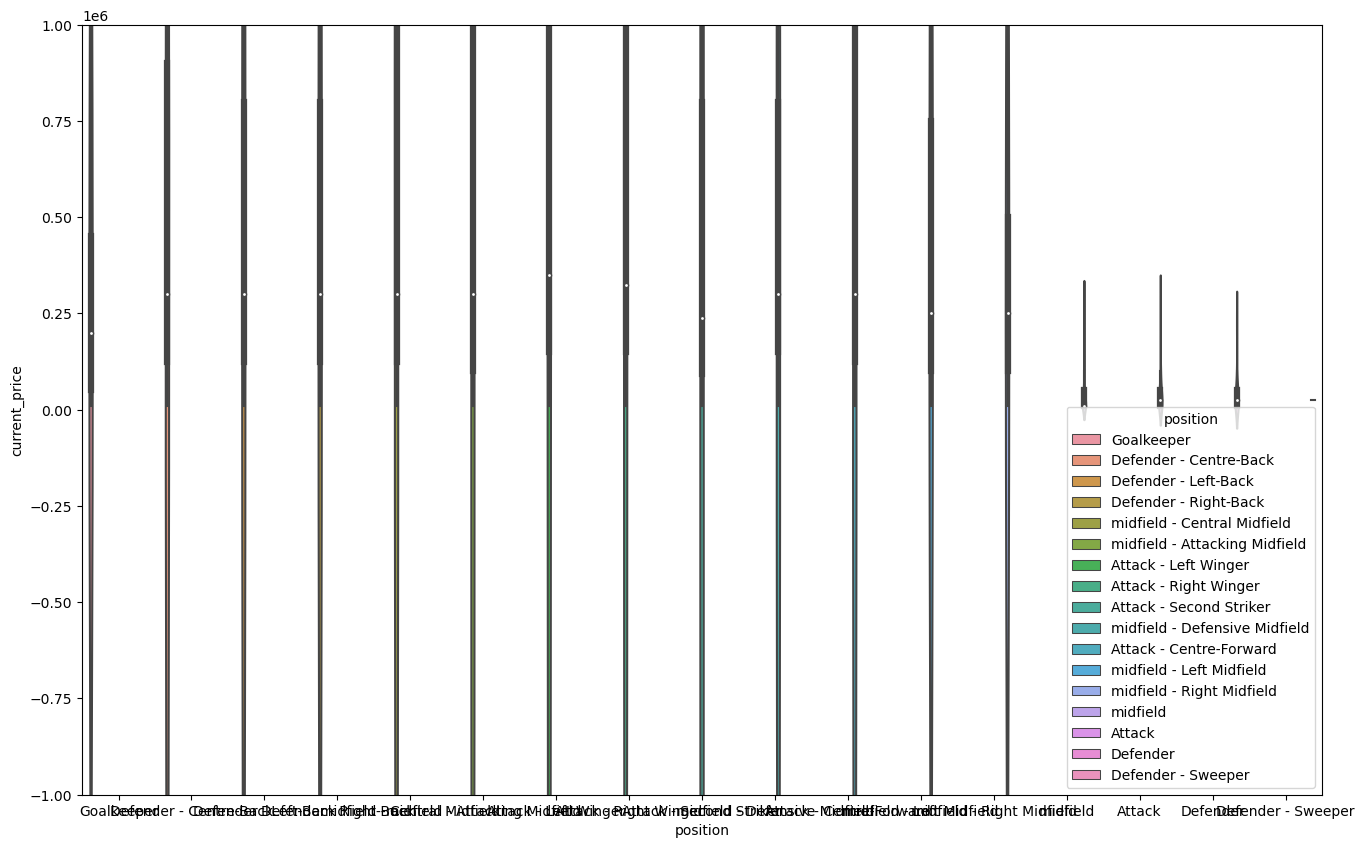

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 10))
sns.violinplot(x = 'position',
               hue='position',
            y = 'current_price',
            data = df)
ax.set_ylim(-1000000, 1e6)
# Show the plot
plt.show()

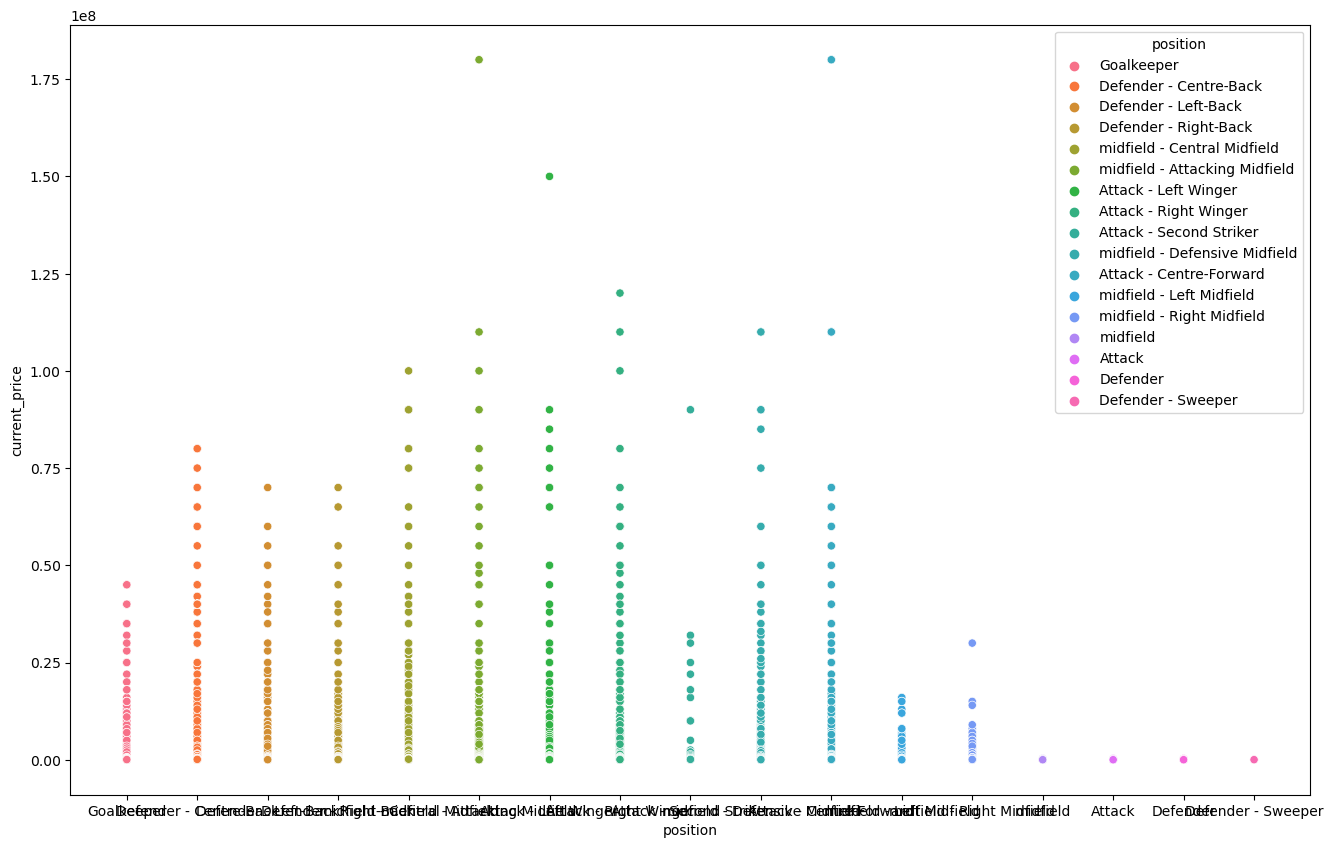

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(x = 'position',
            y = 'current_price',
            hue='position',
            data = df)
# Show the plot
plt.show()

(0.0, 10000000.0)

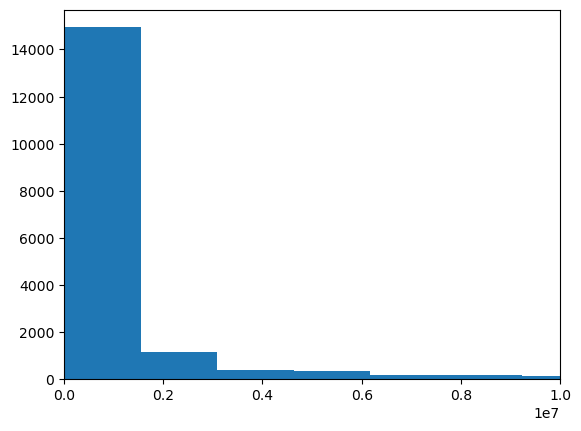

In [136]:
plt.hist(df['current_price'], bins=117)
plt.xlim(0,1e7)